# Grover FoM Conditional Run Demo

We want to run a simple circuit (e.g., a Φ⁺ Bell state) **only if** the backend shows adequate Grover performance.
Grover FoM (GRADE) measures how well a device concentrates probability on marked states while penalizing dispersion and leaks to non-targets.

In this notebook we will:

1. **Define the Grover FoM** (choose number of targets (M), λ and μ; enforce **n ≥ 2** qubits).
2. **Set a score threshold** (e.g., `score > 0.2`) to decide if the backend is “good enough”.
3. **Pick a backend adapter** (Aer or IBM). not checked for IONQ and others.
4. **Configure a compliance check** that evaluates Grover and compares the score to the threshold.
5. **Run conditionally**: if the check **passes**, execute our target circuit (Φ⁺); otherwise run a fallback.
6. **Inspect metrics** (`P_T`, `σ_T`, `P_N`, `score`) and visualize basic results. Visualization can be seen in *Graph FoM*

> Benchmark note: to match literature conventions, keep **transpiler optimization offs** (`optimization_level=0`).


In [1]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeTorino

from qonscious import run_conditionally
from qonscious.actions import QonsciousCallable
from qonscious.adapters import AerSamplerAdapter, IBMSamplerAdapter, IonQBackendAdapter
from qonscious.checks import MeritComplianceCheck
from qonscious.foms import GroverFigureOfMerit

In [2]:
def ghz_circuit() -> QuantumCircuit:
    qc = QuantumCircuit(5, 5)
    qc.h(0)
    for i in range(1, 5):
        qc.cx(0, i)
    qc.measure(range(5), range(5))
    return qc

In [3]:
from qonscious.adapters import BackendAdapter


def on_pass(backend_adapter : BackendAdapter, figureOfMeritResults):
    firstFoMResult = figureOfMeritResults[0]
    print("Grover FoM passed the compliance check!")
    print(f"Score: {firstFoMResult['properties']['score']:.3f}")
    print("Running our GHZ 5 Qbits circuit")
    run_result = backend_adapter.run(ghz_circuit(), shots=2048)
    print("GHZ circuit finished running")
    return run_result

# Este seria el No Op en caso de fallo
fallback = QonsciousCallable(
    lambda adapter, fom_results, **kwargs: None,
)


In [4]:
#Mandatory Grover FoM variables
N_TARGETS =1
L_FACTOR = 0
MU_FACTOR = 0
fom = GroverFigureOfMerit(
    num_targets=N_TARGETS,
    lambda_factor=L_FACTOR,
    mu_factor=MU_FACTOR,
    num_qubits=2,  # Optionally specify number of qubits to build the search space. If not provided 2 is |the minimum.
    #targets_int=[0], # Targets can be specified manually eg. to search for '00000'
)

In [5]:
THRESHOLD = 0.0
def grade_score_over(threshold: float):
    """Función de utilidad para verificar el score GRADE en 'properties'."""
    # Retorna una función lambda que toma el resultado del FoM (r)
    return lambda r: r["properties"]["score"] > threshold

check_grover_is_ok = MeritComplianceCheck(
    figure_of_merit=fom,
    decision_function=lambda r: r["properties"]["score"] > THRESHOLD,
)


In [6]:
backend_adapter = AerSamplerAdapter()
#backend_adapter = IBMSamplerAdapter(FakeManilaV2()) # edit as needed
#backend_adapter = IBMSamplerAdapter(FakeTorino()) # edit as needed

#api_key = "ad your ionq api key here"
#backend_adapter = IonQBackendAdapter.aria_simulator(api_key)

qonscious_result = run_conditionally(
    backend_adapter=backend_adapter,
    checks=[check_grover_is_ok],
    on_pass=QonsciousCallable(on_pass),
    on_fail=fallback,
)

Grover FoM passed the compliance check!
Score: 1.000
Running our GHZ 5 Qbits circuit
GHZ circuit finished running


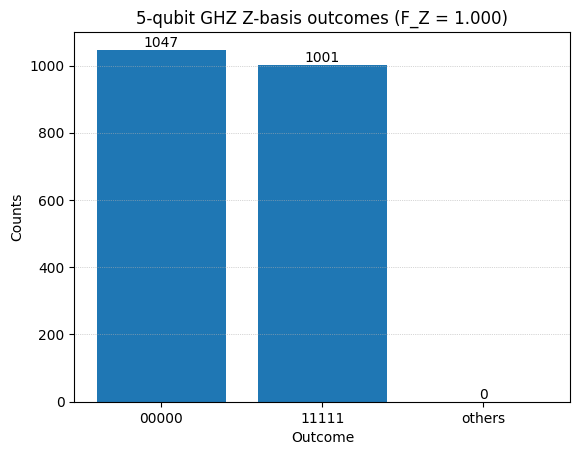

In [7]:
import matplotlib.pyplot as plt

# Get the counts from the last experiment (GHZ on 5 qubits)
counts = qonscious_result["experiment_result"]["counts"]  # type: ignore

n = 5  # number of qubits (GHZ_5)
zero_str = "0" * n      # "00000"
one_str  = "1" * n      # "11111"

ghz0_counts = counts.get(zero_str, 0)
ghz1_counts = counts.get(one_str, 0)
total_counts = sum(counts.values())

others_counts = total_counts - ghz0_counts - ghz1_counts

labels = [zero_str, one_str, "others"]
values = [ghz0_counts, ghz1_counts, others_counts]

N = sum(values)
F_Z = (ghz0_counts + ghz1_counts) / N if N else float("nan")
title = f"5-qubit GHZ Z-basis outcomes (F_Z = {F_Z:.3f})"

fig, ax = plt.subplots()
bars = ax.bar(labels, values)
ax.set_title(title)
ax.set_xlabel("Outcome")
ax.set_ylabel("Counts")
ax.set_ylim(bottom=0)
ax.grid(True, axis="y", linestyle=":", linewidth=0.5)

# Add labels on top of each bar
for bar, value in zip(bars, values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        str(value),
        ha="center", va="bottom"
    )

plt.show()
